In [13]:
import numpy as np
import biotuner
from biotuner.biotuner_utils import *
from biotuner.biotuner_functions import *
from biotuner.biotuner_object import *
import mne

## Load dataset

In [14]:
data = np.load('eeg_data/eeg_ts01.npy')

## Phase-Amplitude Coupling

The comodulogram is a matrix representing the strength of the coupling between the phase of driver frequencies and the amplitude of signal frequencies. The 'pac' method allows to extract pairs of driver/signal frequencies that exhibit higher scores of coupling

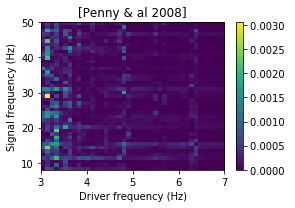

In [15]:
biotuning = biotuner(1000, data = data, peaks_function = 'harmonic_peaks', precision = 0.1, n_harm = 10,
                    ratios_n_harms = 5, ratios_inc_fit = False, ratios_inc = True, scale_cons_limit = 0.1) # Initialize biotuner object
pac_freqs = biotuning.pac(n_values = 30, plot=True, drive_precision = 0.1, max_drive_freq = 7, method = 'penny')

Different methods can be used to compute the PAC:
methods = ['ozkurt', 'canolty', 'tort', 'penny', 'vanwijk', 'duprelatour', 'colgin',
    'sigl', 'bispectrum']

[[3.3, 14.0],
 [3.3, 16.0],
 [3.1, 45.0],
 [3.3, 15.0],
 [3.3, 17.0],
 [3.3, 19.0],
 [3.3, 11.0],
 [3.1, 40.0],
 [3.1, 42.0],
 [3.3, 23.0]]

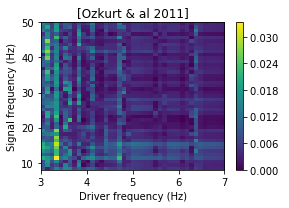

In [16]:
pac_freqs = biotuning.pac(plot=True, drive_precision = 0.1, max_drive_freq = 7, method = 'ozkurt')
pac_freqs

## Deriving tunings from PAC information

By computing the most frequent phase and amplitude frequencies from the 'pac_freqs' lists, we can derive a series of ratios by coupling each phase with each amplitude frequencies

In [17]:
pac_frequent = pac_most_frequent(pac_freqs, 3)
pac_frequent

[[23.0, 42.0, 40.0], [3.3, 3.1]]

In [18]:
ratios = []
for i in range(len(pac_frequent[0])):
    for j in range(len(pac_frequent[1])):
        ratios.append(rebound(pac_frequent[0][i]/pac_frequent[1][j]))
        
ratios = sorted(ratios)
ratios

[1.5151515151515151,
 1.590909090909091,
 1.6129032258064515,
 1.6935483870967742,
 1.7424242424242424,
 1.8548387096774193]

Another approach to derive tuning based on the information of the Phase-Amplitude Coupling would be to compute the ratios of each pairs of phase/amplitude frequencies, and then to apply the 'scale_reduction' function to extract the most consonant intervals. This is what the pac_mode function does.

In [19]:
pac_mode(pac_freqs, 6, function=dyad_similarity)

[1.0606, 1.2121, 1.6129, 1.6667, 1.6935, 1.8145]

In [20]:
pac_mode(pac_freqs, 10)

[1.0606,
 1.1364,
 1.2121,
 1.2879,
 1.4394,
 1.6129,
 1.6667,
 1.6935,
 1.7424,
 1.8145]

### Using coupled frequencies as generator interval

In [21]:
ratio = rebound(pac_freqs[0][1]/pac_freqs[0][0])
sp.Rational(ratio).limit_denominator(1000)

35/33

In [22]:
limit_steps = 16
stern_brocot_ratio = gen_interval_to_stern_brocot (ratio)
steps = Fraction(stern_brocot_ratio).limit_denominator(16).denominator
gen_int_tuning = sorted(generator_interval_tuning (interval = ratio, steps = steps, octave = 2))
gen_int_tuning

[1.0130228884351171,
 1.0606060606060606,
 1.1248852157943066,
 1.193060077357598,
 1.2653667487126037,
 1.3420556425739736,
 1.4233923481845174,
 1.509658551104791,
 1.6011530087475057,
 1.698192585035233,
 1.801113347764641,
 1.9102717324776495]

## Deriving euclidian rhythms from PAC information

In [23]:
from biotuner.dictionaries import *
pac_scale = pac_mode(pac_freqs, 10, function=dyad_similarity)
euclid_final, cons = consonant_euclid(pac_scale, n_steps_down = 3, limit_denom = 4, 
                                      limit_cons =1, limit_denom_final = 100)
interval_vectors = [interval_vector(x) for x in euclid_final]
strings = interval_vec_to_string(interval_vectors)
euclid_referent = euclid_string_to_referent(strings, dict_rhythms)
euclid_final, interval_vectors, euclid_referent

([[1, 0],
  [1, 0, 0],
  [1, 0, 0, 0],
  [1, 0, 0, 0, 1, 0, 0, 0],
  [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
  [1, 0, 0, 1, 0, 0],
  [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
  [1, 0, 1, 0, 1, 0],
  [1, 0, 1, 0, 1, 0, 1, 0],
  [1, 1, 0],
  [1, 1, 0, 1, 1, 0],
  [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
  [1, 1, 1, 0],
  [1, 1, 1, 0, 1, 1, 1, 0],
  [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0]],
 [[2],
  [3],
  [4],
  [4, 4],
  [4, 4, 4],
  [3, 3],
  [3, 3, 3, 3],
  [2, 2, 2],
  [2, 2, 2, 2],
  [1, 2],
  [1, 2, 1, 2],
  [1, 2, 1, 2, 1, 2, 1, 2],
  [1, 1, 2],
  [1, 1, 2, 1, 1, 2],
  [1, 1, 2, 1, 1, 2, 1, 1, 2]],
 ['None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'It is periodic with four repetitions of E(1,3) = [100]. It is the (12/8)-time Fandago clapping pattern in the Flamenco music of southern Spain, where 1 denotes a loud clap and 0 soft clap.',
  'None',
  'None',
  'A common Afro-Cuban drum pattern when started on the second onset as in [101]. For example, it is the conga rhythm of the (6